In [43]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

from collections import Counter


KMER = 6
DIR_EXP = Path(f"../experiments-paper/{KMER}mer")
NAME_EXPERIMENT = "07_25_2024-autoencoder"

path_experiment = DIR_EXP.joinpath(NAME_EXPERIMENT)


labels issues and outliers are saved in the order of the test sets used for kfold cross-validation
___
Get labels from kfold cross-validation

In [46]:
kfold_test = list(
    path_experiment.joinpath("cross-validation").glob("test*")
)
kfold_test.sort()

paths_fcgr = []
labels = []

for kfold in kfold_test:

    with open(kfold) as fp:
        for line in fp.readlines():
            path_fcgr, label = line.strip().split("\t")

            # if path_fcgr not in df_outliers.path:
            labels.append(label)
            paths_fcgr.append(path_fcgr)

df_labels = pd.DataFrame({
    "path_fcgr": paths_fcgr,
    "label": labels
})
df_labels["sample_id"] = df_labels.path_fcgr.apply(lambda s: Path(s).stem)
df_labels["tarfile"] = df_labels.path_fcgr.apply(lambda s: Path(s).parent.stem)
df_labels.head()

,path_fcgr,label,sample_id,tarfile
0,data/fcgr/6mer/salmonella_enterica__20/SAMN060...,salmonella_enterica,SAMN06034028,salmonella_enterica__20
1,data/fcgr/6mer/escherichia_coli__21/SAMN097384...,escherichia_coli,SAMN09738459,escherichia_coli__21
2,data/fcgr/6mer/salmonella_enterica__46/SAMN103...,salmonella_enterica,SAMN10391382,salmonella_enterica__46
3,data/fcgr/6mer/neisseria_meningitidis__02/SAME...,neisseria_meningitidis,SAMEA2147963,neisseria_meningitidis__02
4,data/fcgr/6mer/salmonella_enterica__18/SAMN053...,salmonella_enterica,SAMN05357778,salmonella_enterica__18


get mapping integer label -> species label

In [47]:
unique_labels = list(df_labels.label.unique())
unique_labels.sort()
dict_int2label = {idx: label for idx, label in enumerate(unique_labels)}

### Outliers
___

In [7]:
# outliers
df_outliers = pd.read_csv( path_experiment.joinpath("cross-validation/outliers/outliers.csv"), sep="\t") 

In [8]:
df_outliers.head()

,Unnamed: 0,path,label,avg_dist
0,3096,data/fcgr/7mer/dustbin__11/SAMN02198976.npy,desulfovibrio_sp._g11,0.787206
1,108651,data/fcgr/7mer/dustbin__07/SAMN01779544.npy,staphylococcus_simulans,0.707801
2,37555,data/fcgr/7mer/salmonella_enterica__14/SAMN037...,salmonella_enterica,0.706409
3,37677,data/fcgr/7mer/dustbin__11/SAMN02745672.npy,haliscomenobacter_hydrossis,0.688854
4,4050,data/fcgr/7mer/escherichia_coli__08/SAMN021987...,escherichia_coli,0.682745


In [9]:
df_outliers.groupby("label").size().sort_values(ascending=False)

label
escherichia_coli               277
staphylococcus_aureus          218
salmonella_enterica            189
mycobacterium_tuberculosis     144
streptococcus_pneumoniae       110
                              ... 
achromobacter_insolitus          1
achromobacter_sp._aonih1         1
acidihalobacter_prosperus        1
acidimicrobium_ferrooxidans      1
acidiphilium_multivorum          1
Length: 1641, dtype: int64

### Label issues
___

In [49]:
# label issues
path_cf = path_experiment.joinpath("cross-validation/confident-learning")
int_labels = np.load( path_cf.joinpath("labels.npy") )  # integer labels
labels = [dict_int2label[int(x)] for x in int_labels]   # species name labels
len(labels)

657775

In [51]:
pred_probs = np.load( path_cf.joinpath("pred_probs.npy") )
preds = [dict_int2label[int(x)] for x in pred_probs.argmax(axis=1) ]
df_labels["pred"] = preds
len(preds)

657775

In [29]:
label_issues = np.load( path_cf.joinpath("label_issues.npy") ) 
df_labels_issues = df_labels.loc[label_issues].copy()
df_labels_issues

,path_fcgr,label,sample_id,pred
4,data/fcgr/7mer/neisseria_gonorrhoeae__01/SAMEA...,neisseria_gonorrhoeae,SAMEA2738488,neisseria_meningitidis
89,data/fcgr/7mer/dustbin__10/SAMEA102065668.npy,sagittula_sp._p11,SAMEA102065668,methylobacterium_sp._17sd2-17
161,data/fcgr/7mer/klebsiella_pneumoniae__01/SAMEA...,klebsiella_pneumoniae,SAMEA1903614,proteus_mirabilis
175,data/fcgr/7mer/klebsiella_quasipneumoniae__01/...,klebsiella_quasipneumoniae,SAMN03280408,klebsiella_pneumoniae
201,data/fcgr/7mer/enterobacter_cloacae__01/SAMN02...,enterobacter_cloacae,SAMN02138545,enterobacter_hormaechei
...,...,...,...,...
658318,data/fcgr/7mer/dustbin__17/SAMEA4427772.npy,citrobacter_werkmanii,SAMEA4427772,escherichia_coli
658336,data/fcgr/7mer/staphylococcus_aureus__11/SAMN0...,staphylococcus_aureus,SAMN05713568,dehalococcoides_mccartyi
658347,data/fcgr/7mer/dustbin__13/SAMN07658642.npy,streptococcus_salivarius,SAMN07658642,mycobacterium_tuberculosis
658370,data/fcgr/7mer/enterobacter_cloacae__01/SAMN05...,enterobacter_cloacae,SAMN05170317,enterobacter_hormaechei


In [30]:
# total
num_label_by_specie = Counter(df_labels.label)

# with label issues
counts = Counter(df_labels_issues.label)
counts_label_issues = pd.DataFrame({"species": counts.keys(), "count": counts.values()})

# add total for species
counts_label_issues["total"] = counts_label_issues["species"].apply(lambda s: num_label_by_specie[s])
counts_label_issues["p_issues"] = counts_label_issues.apply(lambda row: row["count"]/row["total"],axis=1)


<Axes: xlabel='count', ylabel='species'>

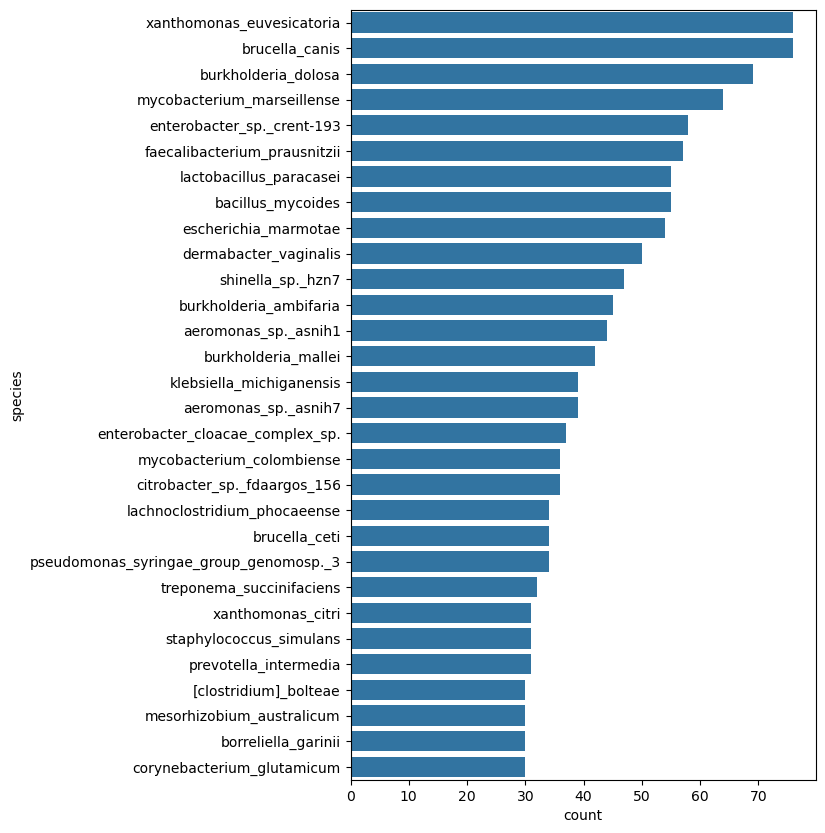

In [31]:
fix, ax = plt.subplots(figsize=(6,10))


feat = "count"
counts_label_issues.sort_values(by=feat, ascending=False, inplace=True)
counts_label_issues.reset_index(inplace=True, drop=True)

sns.barplot(
    data=counts_label_issues.query("total < 100").head(30),
    y="species", x=feat,
    orient="h",
    ax=ax
)

In [32]:
counts_label_issues.query("total < 100").head(20) 

,species,count,total,p_issues
25,xanthomonas_euvesicatoria,76,82,0.926829
27,brucella_canis,76,77,0.987013
34,burkholderia_dolosa,69,71,0.971831
35,mycobacterium_marseillense,64,71,0.901408
42,enterobacter_sp._crent-193,58,59,0.983051
43,faecalibacterium_prausnitzii,57,84,0.678571
45,lactobacillus_paracasei,55,74,0.743243
46,bacillus_mycoides,55,59,0.932203
47,escherichia_marmotae,54,96,0.562500
49,dermabacter_vaginalis,50,65,0.769231


In [33]:
df_label_by_species = pd.DataFrame({
    "species": num_label_by_specie.keys(),
    "count": num_label_by_specie.values(),
})

In [34]:
df_label_by_species.query("count>=100")["count"].sum()

np.int64(636368)

In [35]:
df_label_by_species.query("count<100")["count"].sum()

np.int64(22060)

Compare against most abundant species
___

In [36]:
df_most_abundant = pd.read_csv("../data/three_most_abundant-krakenbracken.txt",sep="\t")
df_most_abundant.rename({
    "V2": "species1",
    "V3": "abundancy1",
    "V4": "species2",
    "V5": "abundancy2",
    "V6": "species3",
    "V7": "abundancy3",
}, inplace=True, axis=1)

In [37]:
df_most_abundant.head()

,sample_id,species1,abundancy1,species2,abundancy2,species3,abundancy3
0,SAMD00000344,Lactobacillus hokkaidonensis,99.093,Lactobacillus plantarum,0.159,Lactobacillus amylophilus,0.110
1,SAMD00000345,Xanthomonas euvesicatoria,27.153,Lactobacillus plantarum,18.485,Lactobacillus brevis,3.043
2,SAMD00000355,Streptococcus pyogenes,97.942,Streptococcus agalactiae,0.883,Streptococcus dysgalactiae,0.858
3,SAMD00000550,Corynebacterium glutamicum,93.780,[Brevibacterium] flavum,2.292,Corynebacterium crudilactis,1.066
4,SAMD00000552,Corynebacterium glutamicum,99.951,Kluyveromyces marxianus,0.015,Acetobacter pasteurianus,0.012


In [38]:
pd.merge(left=df_labels_issues, right=df_most_abundant ,how="left", on="sample_id")

,path_fcgr,label,sample_id,pred,species1,abundancy1,species2,abundancy2,species3,abundancy3
0,data/fcgr/7mer/neisseria_gonorrhoeae__01/SAMEA...,neisseria_gonorrhoeae,SAMEA2738488,neisseria_meningitidis,Neisseria gonorrhoeae,97.113,Neisseria meningitidis,1.058,Neisseria mucosa,0.323
1,data/fcgr/7mer/dustbin__10/SAMEA102065668.npy,sagittula_sp._p11,SAMEA102065668,methylobacterium_sp._17sd2-17,Sagittula sp. P11,4.628,Rhodobacter sphaeroides,3.243,Paracoccus contaminans,3.123
2,data/fcgr/7mer/klebsiella_pneumoniae__01/SAMEA...,klebsiella_pneumoniae,SAMEA1903614,proteus_mirabilis,Klebsiella pneumoniae,83.495,Proteus vulgaris,3.239,Escherichia coli,2.870
3,data/fcgr/7mer/klebsiella_quasipneumoniae__01/...,klebsiella_quasipneumoniae,SAMN03280408,klebsiella_pneumoniae,Klebsiella quasipneumoniae,38.378,Klebsiella pneumoniae,26.611,Enterobacteriaceae bacterium S05,18.128
4,data/fcgr/7mer/enterobacter_cloacae__01/SAMN02...,enterobacter_cloacae,SAMN02138545,enterobacter_hormaechei,Enterobacter cloacae,86.855,Enterobacter hormaechei,10.714,Escherichia coli,0.425
...,...,...,...,...,...,...,...,...,...,...
15513,data/fcgr/7mer/dustbin__17/SAMEA4427772.npy,citrobacter_werkmanii,SAMEA4427772,escherichia_coli,Citrobacter werkmanii,21.307,Citrobacter freundii,13.608,Enterobacter cloacae,6.807
15514,data/fcgr/7mer/staphylococcus_aureus__11/SAMN0...,staphylococcus_aureus,SAMN05713568,dehalococcoides_mccartyi,Staphylococcus aureus,42.258,Corynebacterium pseudotuberculosis,12.820,Gottschalkia acidurici,9.608
15515,data/fcgr/7mer/dustbin__13/SAMN07658642.npy,streptococcus_salivarius,SAMN07658642,mycobacterium_tuberculosis,Streptococcus salivarius,21.044,Streptococcus mitis,7.123,Streptococcus parasanguinis,6.784
15516,data/fcgr/7mer/enterobacter_cloacae__01/SAMN05...,enterobacter_cloacae,SAMN05170317,enterobacter_hormaechei,Enterobacter cloacae,53.119,Enterobacter hormaechei,35.109,Enterobacter sp. CRENT-193,4.694


In [40]:
df_labels_issues

,path_fcgr,label,sample_id,pred,tarfile,id
4,data/fcgr/7mer/neisseria_gonorrhoeae__01/SAMEA...,neisseria_gonorrhoeae,SAMEA2738488,neisseria_meningitidis,neisseria_gonorrhoeae__01,SAMEA2738488
89,data/fcgr/7mer/dustbin__10/SAMEA102065668.npy,sagittula_sp._p11,SAMEA102065668,methylobacterium_sp._17sd2-17,dustbin__10,SAMEA102065668
161,data/fcgr/7mer/klebsiella_pneumoniae__01/SAMEA...,klebsiella_pneumoniae,SAMEA1903614,proteus_mirabilis,klebsiella_pneumoniae__01,SAMEA1903614
175,data/fcgr/7mer/klebsiella_quasipneumoniae__01/...,klebsiella_quasipneumoniae,SAMN03280408,klebsiella_pneumoniae,klebsiella_quasipneumoniae__01,SAMN03280408
201,data/fcgr/7mer/enterobacter_cloacae__01/SAMN02...,enterobacter_cloacae,SAMN02138545,enterobacter_hormaechei,enterobacter_cloacae__01,SAMN02138545
...,...,...,...,...,...,...
658318,data/fcgr/7mer/dustbin__17/SAMEA4427772.npy,citrobacter_werkmanii,SAMEA4427772,escherichia_coli,dustbin__17,SAMEA4427772
658336,data/fcgr/7mer/staphylococcus_aureus__11/SAMN0...,staphylococcus_aureus,SAMN05713568,dehalococcoides_mccartyi,staphylococcus_aureus__11,SAMN05713568
658347,data/fcgr/7mer/dustbin__13/SAMN07658642.npy,streptococcus_salivarius,SAMN07658642,mycobacterium_tuberculosis,dustbin__13,SAMN07658642
658370,data/fcgr/7mer/enterobacter_cloacae__01/SAMN05...,enterobacter_cloacae,SAMN05170317,enterobacter_hormaechei,enterobacter_cloacae__01,SAMN05170317
